<a href="https://colab.research.google.com/github/hublun/Bayesian_Aggregation_Average_Data/blob/master/Jax_2024_1_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Using the OpenAI Library to Programmatically Access GPT-3.5-turbo!

This notebook was authored by [DRC Lab](http://www.dulun.com/)

In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [2]:
!nvidia-smi

Fri Jan 19 14:27:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import jax

In [4]:
jax.devices()

[cuda(id=0)]

In [5]:
from jax import grad
import jax.numpy as jnp

def tanh(x):  # Define a function
  y = jnp.exp(-2.0 * x)
  return (1.0 - y) / (1.0 + y)

grad_tanh = grad(tanh)  # Obtain its gradient function
print(grad_tanh(1.0))   # Evaluate it at x = 1.0

0.4199743




---



In [6]:
x = jnp.array([1.0, 2.0, 3.0], dtype=jnp.float32)
x
x.shape

(3,)

In [7]:
x.at[1].set(4)

Array([1., 4., 3.], dtype=float32)

This is because sometimes we might want to run code on a vector processor like a GPU or TPU that we can use JAX for, or we might prefer to run some code on a CPU in NumPy.

```
The other point to note is that JAX tensors have shape. This is usually a tuple, so (3,) means a three-dimensional

vector along the first axis. A matrix has two axes, and a tensor has three or more axes.
```



Now we come to places where JAX differs from NumPy. It is really important to pay attention to “[JAX—The Sharp Bits](https://oreil.ly/qqcFM)” to understand these differences. JAX’s philosophy is about speed and purity. By making functions pure (without side effects) and by making data immutable, JAX is able to make some guarantees to the underlying accelerated linear algebra (XLA) library that it uses to talk to GPUs. JAX guarantees that these functions applied to data can be run in parallel and have deterministic results without side effects, and thus XLA is able to compile these functions and make them run much faster than if they were run just on NumPy.

In [8]:
x = jnp.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype=jnp.int32)
x.shape


(3, 3)



---



In [10]:
print(x[0])
print(x[-1])

[1 2 3]
[7 8 9]


In [11]:
print(x[:,1])

[2 5 8]


In [12]:
# Print every other element
print(x[::2, ::2])

[[1 3]
 [7 9]]


In [13]:
y = 2*x
y

Array([[ 2,  4,  6],
       [ 8, 10, 12],
       [14, 16, 18]], dtype=int32)

In [14]:
vec = jnp.reshape(jnp.array([0.5, 1.0, 2.0]), [3, 1])
vec

Array([[0.5],
       [1. ],
       [2. ]], dtype=float32)

In [15]:
vec * x

Array([[ 0.5,  1. ,  1.5],
       [ 4. ,  5. ,  6. ],
       [14. , 16. , 18. ]], dtype=float32)

In [17]:
jnp.reshape(vec, (1,3)) * x

Array([[ 0.5,  2. ,  6. ],
       [ 2. ,  5. , 12. ],
       [ 3.5,  8. , 18. ]], dtype=float32)

In [19]:
import jax.random as random

In [21]:
key = random.PRNGKey(0)
x = random.uniform(key, shape=[3, 3])
x

Array([[0.35490513, 0.60419905, 0.4275843 ],
       [0.23061597, 0.6735498 , 0.43953657],
       [0.25099766, 0.27730572, 0.7678207 ]], dtype=float32)

In [23]:
key, subkey = random.split(key)
x = random.uniform(key, shape=[3, 3])
x

Array([[0.8494284 , 0.13328338, 0.82961345],
       [0.24099779, 0.44065714, 0.23725045],
       [0.19817984, 0.86455667, 0.22237241]], dtype=float32)

In [24]:
y = random.uniform(subkey, shape=[3, 3])
print(y)

[[0.46436882 0.9362588  0.3402921 ]
 [0.79412293 0.02270031 0.6626308 ]
 [0.84614086 0.5032078  0.7358694 ]]


In [25]:
x = random.uniform(key, shape=[2048, 2048]) - 0.5

def my_function(x):
  x = x @ x
  return jnp.maximum(0.0, x)

In [33]:
%timeit my_function(x).block_until_ready()

3.93 ms ± 31.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [31]:
my_function_jitted = jax.jit(my_function)

In [32]:
%timeit my_function_jitted(x).block_until_ready()

3.93 ms ± 24.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [36]:
import seaborn as sns

_ = jnp.nan
scores = jnp.array([[5,4,4,1],
    [2,3,3,4.5],
    [3,2,3,4],
    [4,4,5,_],
    [3,_,_,_]])

<Axes: >

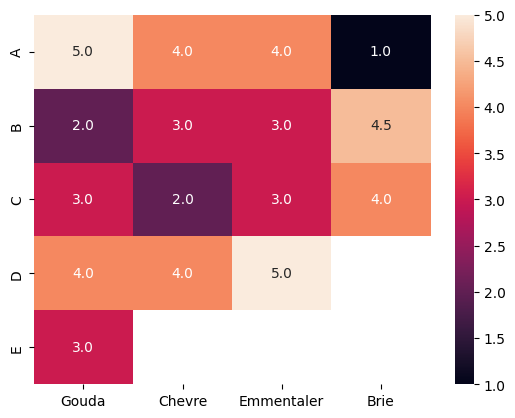

In [37]:
sns.heatmap(
    scores,
    annot=True,
    fmt=".1f",
    xticklabels=['Gouda', 'Chevre', 'Emmentaler', 'Brie',],
    yticklabels=['A','B','C','D','E',]
)